In [2]:
%load_ext rpy2.ipython

import os
from json import loads as jloads
from glob import glob
import pandas as pd
import datetime

In [3]:
resdir = '/Users/dcdanko/athena-scratch/projects/nasa/twin_study/analysis/metasub_cap/.module_ultra/core_results/'

fecal_metadata = pd.read_csv('/Users/dcdanko/Dropbox/Projects/NASA_twin_microbiome/fecal_metadata.csv')

def samp(fname):
    return fname.split('/')[-1].split('.')[0]


def kind(fname):
    sname = samp(fname)
    if sname[0] == 'B':
        return 'buccal'
    elif sname[0] == 'M':
        return 'fecal'
    else:
        return 'saliva'
    
def twin(fname):
    sname = samp(fname)
    if 'TW' in sname:
        return 'TW'
    elif 'HR' in sname:
        return 'HR'
    else:
        return 'unk'
    
def date(fname):
    sname = samp(fname)
    k = kind(fname)
    if  k == 'fecal':
        try:
            dstr = fecal_metadata.at[sname, 'date'][0]
        except KeyError:
            return 'unk'
        month, day, year = dstr.split('/')
    else:
        if k == 'buccal':
            dstr = sname.split('B_')[1]
        else:
            dstr = sname
        dstr = dstr.split('_')[0]
        month, day, year = int(dstr[:2]), int(dstr[2:4]), int(dstr[4:6])
    return '{}-{}-{}'.format(day, month, year)

def flight(fname):
    try:
        d = datetime.date(*[int(el) for el in date(fname).split('-')[::-1]])
    except ValueError:
        return 'unk'
    t = twin(fname)
    if t != 'TW':
        return 'ground'
    launch = datetime.date(15, 3, 27)
    land = datetime.date(16, 3, 2)
    afterlaunch = (d - launch).days >= 0
    beforeland = (d - land).days <= 0
    if  afterlaunch and beforeland:
        return 'flight'
    return 'ground'


In [8]:
%%R

library(gplots)
library(ggplot2)
library(reshape2)
library(gridExtra)

ascols = function(facs, pallette){
    facs = facs[,1]
    ffacs = as.factor(as.character(facs))
    n = length(unique(facs))
    cols = pallette(n)[ffacs]
}


In [5]:

obj = jloads(open(resdir + 'fecal_samples.beta_diversity_stats.json.json').read())
fobj = obj['species']['rho_proportionality']['kraken']
fbetaDF = pd.DataFrame(fobj)

mdata = {'twin': {}, 'flight': {}, 'date': {}}
for sname in fobj:
    mdata['twin'][sname] = twin(sname)
    mdata['date'][sname] = date(sname)
    mdata['flight'][sname] = flight(sname)

mdata = pd.DataFrame(mdata)
mdata

,date,flight,twin
MHV-HR1_S41667382,29-12-14,ground,HR
MHV-HR2_S41666347,30-1-15,ground,HR
MHV-HR3_S41658400,30-7-15,ground,HR
MHV-HR4_S41677053,21-9-15,ground,HR
MHV-HR5_S41659407,19-1-16,ground,HR
MHV-HR6_S41664399,4-3-16,ground,HR
MHV-HR7_S41668198,5-5-16,ground,HR
MHV-HR8_S41669183,17-7-16,ground,HR
MHV-HR9_S41667391,30-8-16,ground,HR
MHV-TW1_S41667392,16-10-14,ground,TW


# Beta Diversity

## Beta Diversity Fecal

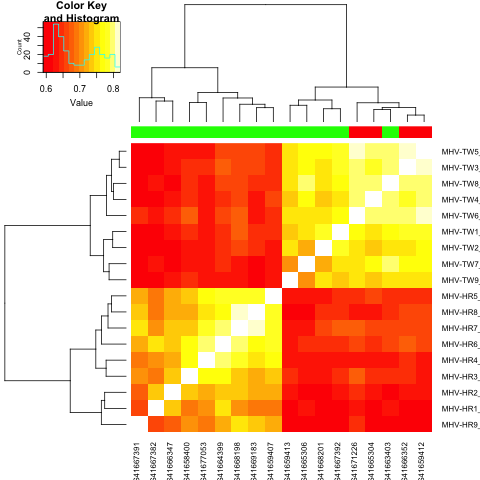

In [568]:
%%R -i fbetaDF -i mdata


beta.df = as.matrix(fbetaDF)
diag(beta.df) = NA
cols = ascols(mdata['flight'], rainbow)

gud = mdata['twin'] != 'unk'
beta.df = beta.df[gud,gud]

heatmap.2(beta.df, trace='none', ColSideColors=cols[gud])






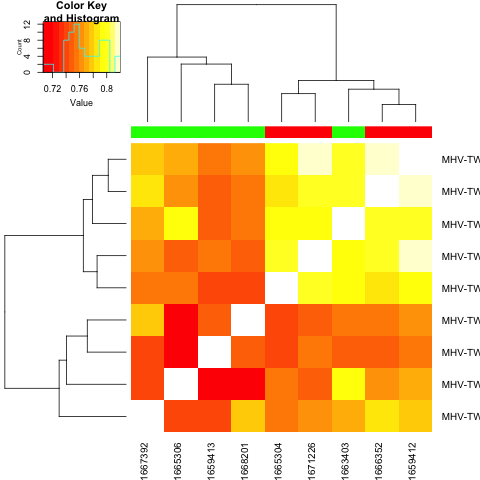

In [569]:
%%R -i fbetaDF -i mdata


beta.df = as.matrix(fbetaDF)
diag(beta.df) = NA
cols = ascols(mdata['flight'], rainbow)
tw = mdata['twin'] == 'TW'
tw.beta = beta.df[tw,tw]
heatmap.2(tw.beta, trace='none', ColSideColors=cols[tw])

## Beta Diversity Saliva

In [570]:
obj = jloads(open(resdir + 'saliva_samples.beta_diversity_stats.json.json').read())
obj = obj['species']['rho_proportionality']['kraken']
betaDF = pd.DataFrame(obj)

mdata = {'twin': {}, 'flight': {}, 'date': {}}
for sname in obj:
    mdata['twin'][sname] = twin(sname)
    mdata['date'][sname] = date(sname)
    mdata['flight'][sname] = flight(sname)

mdata = pd.DataFrame(mdata)

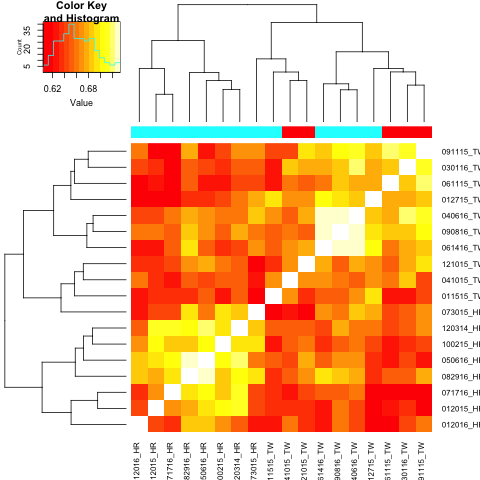

In [571]:
%%R -i betaDF -i mdata


beta.df = as.matrix(betaDF)
diag(beta.df) = NA
cols = ascols(mdata['flight'], rainbow)
heatmap.2(beta.df, trace='none', ColSideColors=cols)



# Alpha Diversity

In [572]:
alphas = glob(resdir + '*alpha*.json')

def alpha(fname):
    obj = jloads(open(fname).read())
    return obj['genus']['shannon_index']['kraken']

alphasDF = {'H': {}, 'kind': {}, 'twin': {}, 'date': {}}
for fname in alphas:
    alphasDF['H'][samp(fname)] = alpha(fname)
    alphasDF['kind'][samp(fname)] = kind(fname)
    alphasDF['twin'][samp(fname)] = twin(fname)
    alphasDF['date'][samp(fname)] = date(fname)
    
alphasDF = pd.DataFrame(alphasDF)


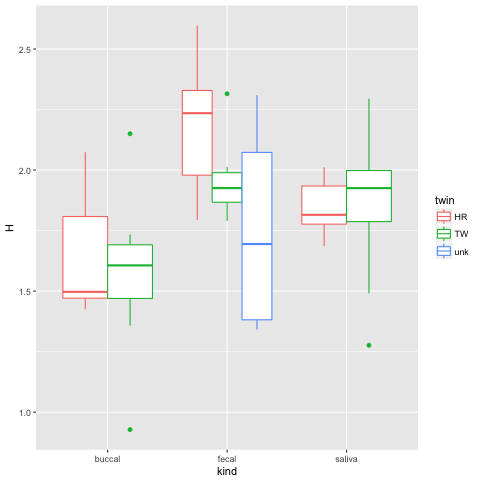

In [573]:
%%R -i alphasDF

library(ggplot2)

ggplot(alphasDF, aes(x=kind, y=H, colour=twin)) + 
    geom_boxplot()

## Alpha Diversity Saliva

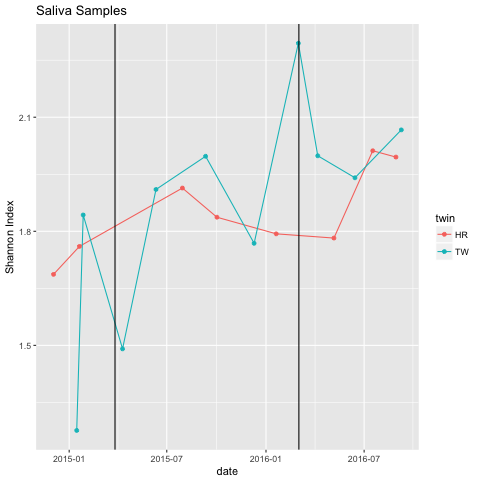

In [596]:
%%R


a.df.s = alphasDF[alphasDF['kind'] == 'saliva',]
a.df.s['date'] = lapply(a.df.s['date'], FUN= function(d){return(as.Date(d, "%d-%m-%y"))})

ggplot(a.df.s, aes(x=date, y=H, colour=twin, group=twin)) +
  geom_line() + 
    geom_point() +
    geom_vline(xintercept=as.Date("27-03-15", "%d-%m-%y")) + 
    geom_vline(xintercept=as.Date("02-03-16", "%d-%m-%y")) +
        ggtitle('Saliva Samples') +
    ylab('Shannon Index')


## Alpha Diversity Fecal

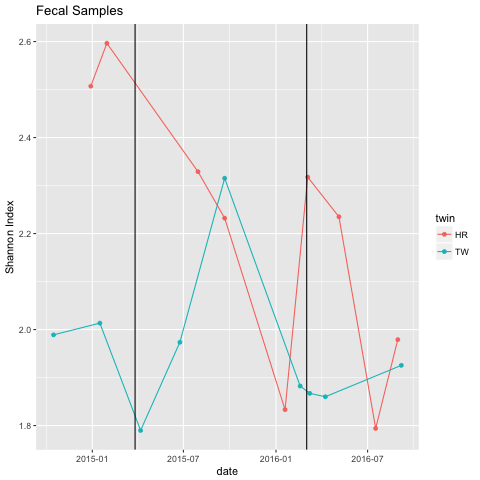

In [597]:
%%R


a.df.f = alphasDF[alphasDF['kind'] == 'fecal',]
a.df.f['date'] = lapply(a.df.f['date'], FUN= function(d){return(as.Date(d, "%d-%m-%y"))})
a.df.f = a.df.f[a.df.f['twin'] != 'unk',]
ggplot(a.df.f, aes(x=date, y=H, colour=twin, group=twin)) +
  geom_line() + 
    geom_point() +
    geom_vline(xintercept=as.Date("27-03-15", "%d-%m-%y")) + 
    geom_vline(xintercept=as.Date("02-03-16", "%d-%m-%y")) + 
    ggtitle('Fecal Samples') +
    ylab('Shannon Index')
    
    
    

In [576]:

propfs = glob(resdir + '*classification_proportions*.json')

def props(fname):
    obj = jloads(open(fname).read())
    return {k: v for k, v in obj['proportions'].items() if k != 'total'}


propsDF = {'kind': {}, 'twin': {}, 'flight': {}, 'date': {}}
for fname in propfs:
    for k, v in props(fname).items():
        propsDF['kind'][samp(fname)] = kind(fname)
        propsDF['twin'][samp(fname)] = twin(fname)
        propsDF['flight'][samp(fname)] = flight(fname)
        propsDF['date'][samp(fname)] = date(fname)
        
        try:
            propsDF[k][samp(fname)] = v
        except KeyError:
            propsDF[k] = {samp(fname): v}
    
propsDF = pd.DataFrame(propsDF)


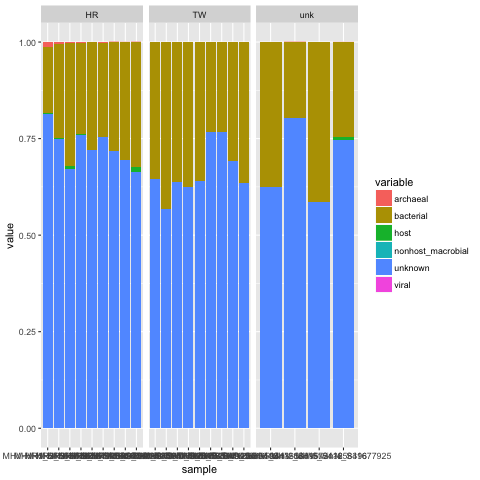

In [577]:
%%R -i propsDF


p.df = propsDF
p.df['sample'] = rownames(p.df)


p.df.f = p.df[p.df['kind'] == 'fecal',]
p.df.f = melt(p.df.f, id.vars=c('sample', 'kind', 'twin', 'flight', 'date'))
#print(dim(p.df.f))

# tw = ggplot(p.df.f[p.df.f$twin == 'TW',], aes(x=sample, y=value)) + 
#        geom_bar(aes(fill=variable), stat='identity')
# hr = ggplot(p.df.f[p.df.f$twin == 'TW',], aes(x=sample, y=value)) + 
#        geom_bar(aes(fill=variable), stat='identity')

ggplot(p.df.f, aes(x=sample, y=value)) + 
        geom_bar(aes(fill=variable), stat='identity') +
        facet_grid(~ twin, scales='free')

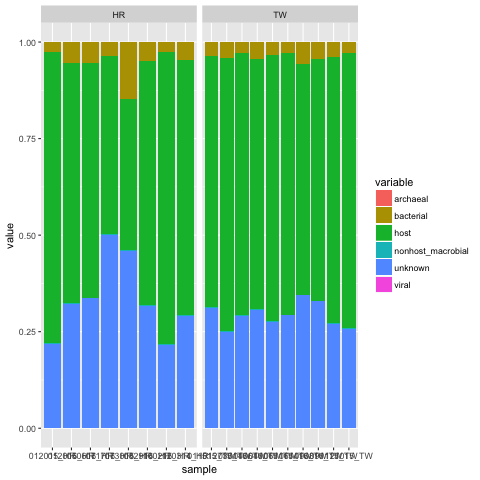

In [578]:
%%R

p.df.s = p.df[p.df['kind'] == 'saliva',]
p.df.s = melt(p.df.s, id.vars=c('sample', 'kind', 'twin', 'flight', 'date'))

ggplot(p.df.s, aes(x=sample, y=value)) + 
        geom_bar(aes(fill=variable), stat='identity') +
        facet_grid(~ twin, scales='free')

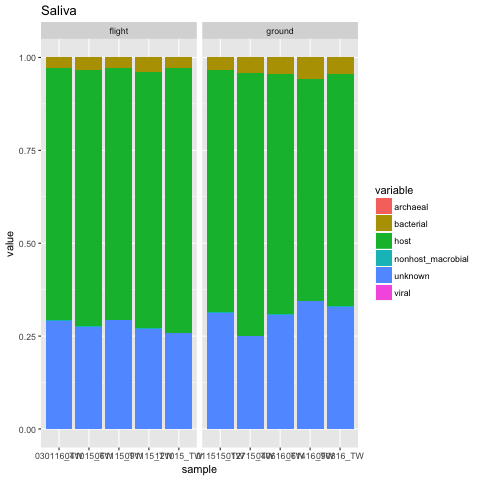

In [598]:
%%R 

p.df.s.tw = p.df.s[p.df.s['twin'] == 'TW',]

ggplot(p.df.s.tw, aes(x=sample, y=value)) + 
        geom_bar(aes(fill=variable), stat='identity') +
        facet_grid(~ flight, scales='free') +
        ggtitle('Saliva')


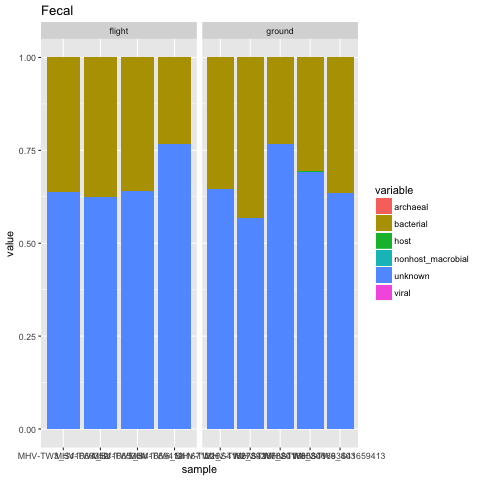

In [600]:
%%R 

p.df.f.tw = p.df.f[p.df.f['twin'] == 'TW',]

ggplot(p.df.f.tw, aes(x=sample, y=value)) + 
        geom_bar(aes(fill=variable), stat='identity') +
        facet_grid(~ flight, scales='free') + 
        ggtitle('Fecal')

# Non Bacterial Sequences

## Viral Sequence in Fecal Metagenome

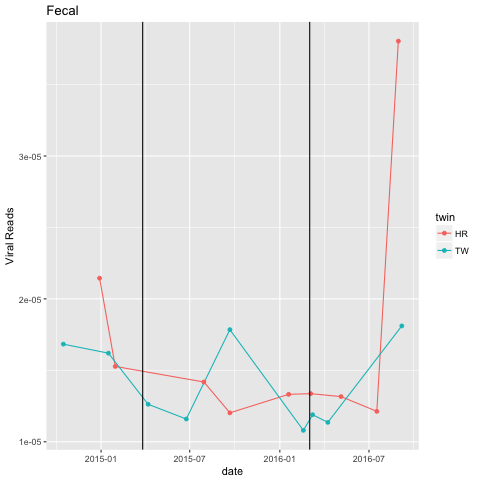

In [602]:
%%R


p.df.fv = p.df.f[p.df.f["variable"] == "viral",]
p.df.fv = p.df.fv[p.df.fv["twin"] != "unk",]
p.df.fv["date"] = lapply(p.df.fv['date'], FUN= function(d){return(as.Date(d, "%d-%m-%y"))})

ggplot(p.df.fv, aes(x=date, y=value,colour=twin, group=twin)) + 
       geom_line() +
    geom_point() +
    geom_vline(xintercept=as.Date("27-03-15", "%d-%m-%y")) + 
    geom_vline(xintercept=as.Date("02-03-16", "%d-%m-%y")) +
    ylab('Viral Reads') +
    ggtitle('Fecal')

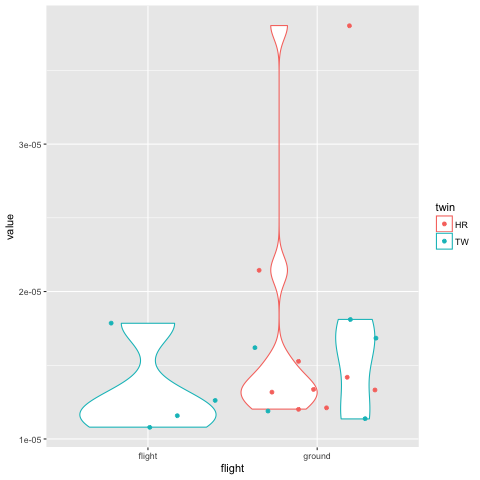

In [582]:
%%R

ggplot(p.df.fv, aes(x=flight, y=value, colour=twin)) + 
       geom_violin() + 
        geom_jitter()

## Host Sequence in Fecal Metagenome

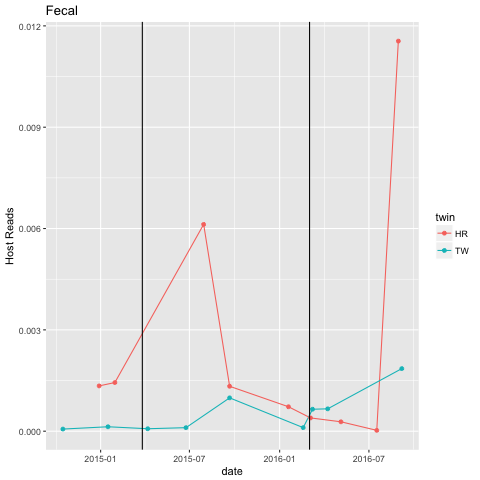

In [604]:
%%R

p.df.fh = p.df.f[p.df.f["variable"] == "host",]
p.df.fh = p.df.fh[p.df.fh["twin"] != "unk",]
p.df.fh["date"] = lapply(p.df.fh['date'], FUN= function(d){return(as.Date(d, "%d-%m-%y"))})


ggplot(p.df.fh, aes(x=date, y=value,colour=twin, group=twin)) + 
       geom_line() +
    geom_point() +
    geom_vline(xintercept=as.Date("27-03-15", "%d-%m-%y")) + 
    geom_vline(xintercept=as.Date("02-03-16", "%d-%m-%y")) +
    ggtitle('Fecal') +
    ylab('Host Reads')

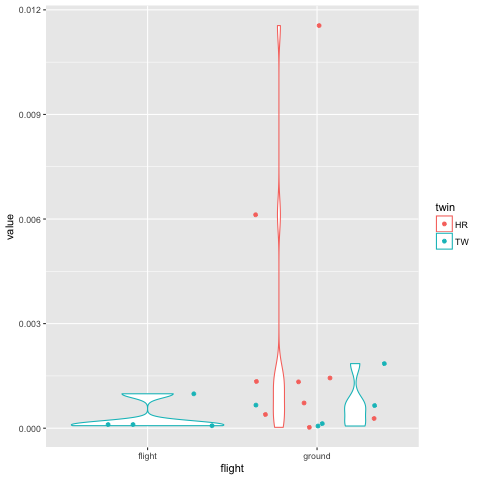

In [584]:
%%R

ggplot(p.df.fh, aes(x=flight, y=value, colour=twin)) + 
       geom_violin() + 
        geom_jitter()

## Viral Sequence in Saliva

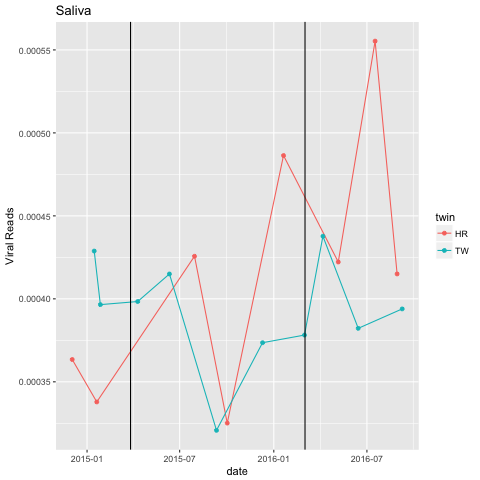

In [603]:
%%R


p.df.sv = p.df.s[p.df.s["variable"] == "viral",]
p.df.sv = p.df.sv[p.df.sv["twin"] != "unk",]
p.df.sv["date"] = lapply(p.df.sv['date'], FUN= function(d){return(as.Date(d, "%d-%m-%y"))})

ggplot(p.df.sv, aes(x=date, y=value,colour=twin, group=twin)) + 
       geom_line() +
    geom_point() +
    geom_vline(xintercept=as.Date("27-03-15", "%d-%m-%y")) + 
    geom_vline(xintercept=as.Date("02-03-16", "%d-%m-%y")) +
    ggtitle('Saliva') +
    ylab('Viral Reads')
    
    
    
    



# Microbe Directory Annotations

## COGEM

In [606]:
mdbfs = glob(resdir + '*.microbe_directory_annotate.json.json')

def mdbs(fname):
    obj = jloads(open(fname).read())
    return {k: v for k, v in obj['pathogenicity'].items()}

mdbsDF = {'kind': {}, 'twin': {}, 'flight': {}, 'date': {}}
for fname in mdbfs:
    for k, v in mdbs(fname).items():
        mdbsDF['kind'][samp(fname)] = kind(fname)
        mdbsDF['twin'][samp(fname)] = twin(fname)
        mdbsDF['flight'][samp(fname)] = flight(fname)
        mdbsDF['date'][samp(fname)] = date(fname)
        
        try:
            mdbsDF[k][samp(fname)] = v
        except KeyError:
            mdbsDF[k] = {samp(fname): v}
    
mdbsDF = pd.DataFrame(mdbsDF)


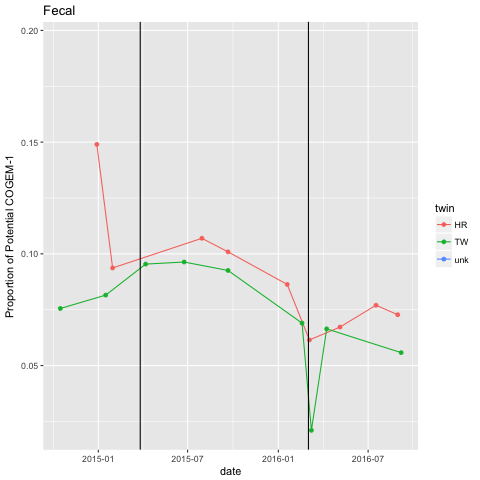

In [607]:
%%R -i mdbsDF


m.df = mdbsDF
m.df['sample'] = rownames(m.df)
m.df["date"] = lapply(m.df['date'], FUN= function(d){return(as.Date(d, "%d-%m-%y"))})
m.df = m.df[m.df[,"kind"] == "fecal",]

ggplot(m.df, aes_string(x="date", y="X1.0", colour="twin")) + 
        geom_line() +
        geom_point() +
    geom_vline(xintercept=as.Date("27-03-15", "%d-%m-%y")) + 
    geom_vline(xintercept=as.Date("02-03-16", "%d-%m-%y")) +
    ggtitle('Fecal') +
    ylab('Proportion of Potential COGEM-1')



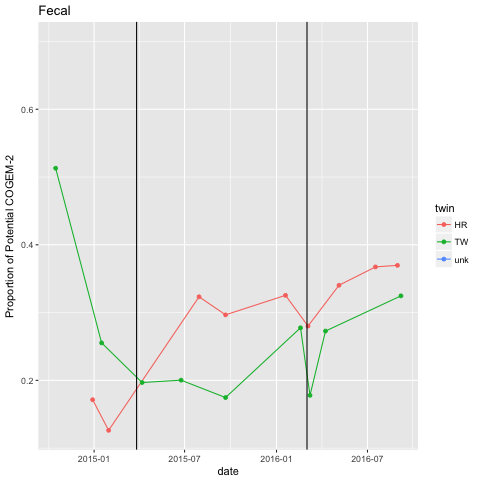

In [609]:
%%R

ggplot(m.df, aes_string(x="date", y="X2.0", colour="twin")) + 
        geom_line() +
        geom_point() +
    geom_vline(xintercept=as.Date("27-03-15", "%d-%m-%y")) + 
    geom_vline(xintercept=as.Date("02-03-16", "%d-%m-%y")) +
    ggtitle('Fecal') +
    ylab('Proportion of Potential COGEM-2')
    
    
    

## Temperature

In [589]:
def mdbs(fname):
    obj = jloads(open(fname).read())
    return sum([float(k) * float(v) for k, v in obj['optimal_temperature'].items() if k != 'NaN'])

mdbsDF = {'kind': {}, 'twin': {}, 'flight': {}, 'date': {}, 'temp': {}}
for fname in mdbfs:
    mdbsDF['kind'][samp(fname)] = kind(fname)
    mdbsDF['twin'][samp(fname)] = twin(fname)
    mdbsDF['flight'][samp(fname)] = flight(fname)
    mdbsDF['date'][samp(fname)] = date(fname)
    mdbsDF['temp'][samp(fname)] = mdbs(fname)

    
mdbsDF = pd.DataFrame(mdbsDF)


                        date flight  kind     temp twin
MHV-HR1_S41667382 2014-12-29 ground fecal 21.09746   HR
MHV-HR2_S41666347 2015-01-30 ground fecal 23.81093   HR
MHV-HR3_S41658400 2015-07-30 ground fecal 21.67837   HR
MHV-HR4_S41677053 2015-09-21 ground fecal 23.47570   HR
MHV-HR5_S41659407 2016-01-19 ground fecal 25.79055   HR
MHV-HR6_S41664399 2016-03-04 ground fecal 17.97929   HR


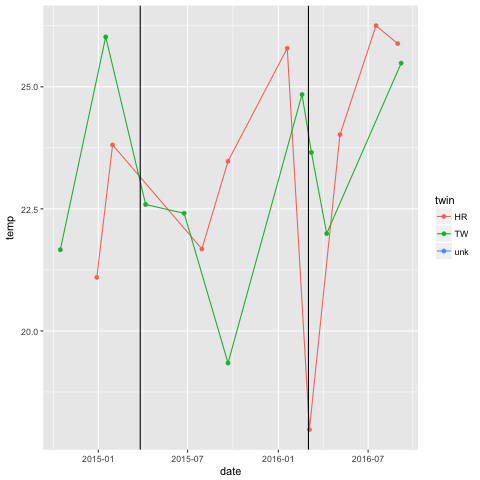

In [590]:
%%R -i mdbsDF


m.df = mdbsDF[mdbsDF["kind"] == "fecal",]
m.df["date"] = lapply(m.df['date'], FUN= function(d){return(as.Date(d, "%d-%m-%y"))})
print(head(m.df))

ggplot(m.df, aes_string(x="date", y="temp", colour="twin")) + 
        geom_line() +
        geom_point() +
    geom_vline(xintercept=as.Date("27-03-15", "%d-%m-%y")) + 
    geom_vline(xintercept=as.Date("02-03-16", "%d-%m-%y"))

# Taxonomy

## Taxonomy PCA

In [6]:


obj = jloads(open(resdir + 'fecal_samples.kraken_group_summary.json.json').read())
both = {k: v for k, v in obj['species'].items() if 'twin' not in k}
tw = {k: v for k, v in obj['species'].items() if 'TW' in k}
taxadf = pd.DataFrame(both).transpose().fillna(0)
twdf = pd.DataFrame(tw).transpose().fillna(0)
mdata

,date,flight,twin
MHV-HR1_S41667382,29-12-14,ground,HR
MHV-HR2_S41666347,30-1-15,ground,HR
MHV-HR3_S41658400,30-7-15,ground,HR
MHV-HR4_S41677053,21-9-15,ground,HR
MHV-HR5_S41659407,19-1-16,ground,HR
MHV-HR6_S41664399,4-3-16,ground,HR
MHV-HR7_S41668198,5-5-16,ground,HR
MHV-HR8_S41669183,17-7-16,ground,HR
MHV-HR9_S41667391,30-8-16,ground,HR
MHV-TW1_S41667392,16-10-14,ground,TW


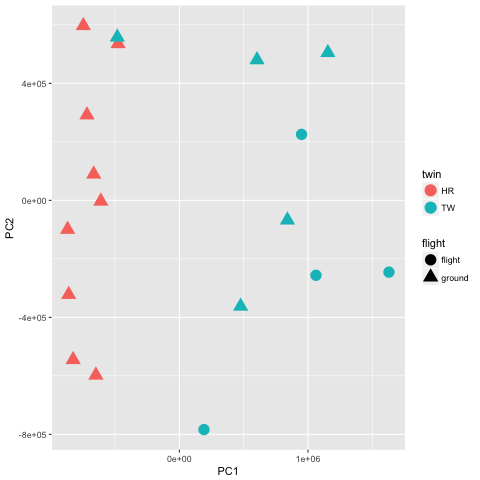

In [12]:
%%R -i taxadf -i mdata

tdf = as.matrix(taxadf)
p = prcomp(tdf)
pcs = p$x[,1:2]
md = mdata[rownames(pcs),]
df = cbind(pcs, md)


ggplot(df, aes(x=PC1, y=PC2, colour=twin, shape=flight)) +
  geom_point(size=5)

In [15]:
%%R

cumsum(p$sdev^2 / sum(p$sdev^2))

 [1] 0.7045607 0.8895879 0.9233687 0.9435860 0.9584471 0.9715886 0.9811862
 [8] 0.9870192 0.9917058 0.9943774 0.9962081 0.9975850 0.9986717 0.9993369
[15] 0.9996529 0.9998655 1.0000000 1.0000000


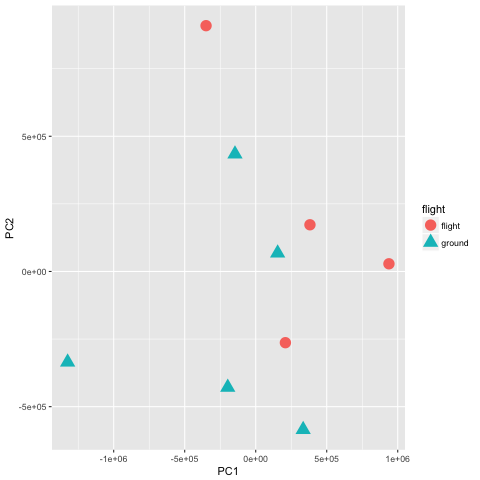

In [16]:
%%R -i twdf -i mdata

tdf = as.matrix(twdf)

p = prcomp(tdf)
pcs = p$x[,1:2]
md = mdata[rownames(pcs),]
df = cbind(pcs, md)

ggplot(df, aes(x=PC1, y=PC2, colour=flight, shape=flight)) +
  geom_point(size=5)

In [18]:
%%R

cumsum(p$sdev^2 / sum(p$sdev^2))

[1] 0.5733027 0.8940292 0.9526439 0.9786310 0.9905762 0.9951098 0.9982838
[8] 1.0000000 1.0000000


## Taxonomy Diff. Abundance

In [19]:
from scipy.stats import ttest_ind

flight = (mdata['flight'] == 'flight')[twdf.index]
ground = (mdata['flight'] == 'ground')[twdf.index]

fldf = twdf[flight].transpose()
grdf = twdf[ground].transpose()

ttestdf = ttest_ind(fldf, grdf, axis=1)[1]
twdf.transpose()[ttestdf < 0.001]


,MHV-TW1_S41667392,MHV-TW2_S41668201,MHV-TW3_S41666352,MHV-TW4_S41665304,MHV-TW5_S41659412,MHV-TW6_S41671226,MHV-TW7_S41665306,MHV-TW8_S41663403,MHV-TW9_S41659413
d__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecalis,1172.0,1781.0,3775.0,2770.0,3304.0,3745.0,1248.0,1893.0,2184.0
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_SY8519,2904.0,3491.0,4749.0,4087.0,4602.0,5294.0,2740.0,3248.0,3215.0
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__[Ruminococcus]_obeum,82121.0,108870.0,146243.0,127718.0,134242.0,141317.0,71125.0,89852.0,90011.0
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_catus,25546.0,35167.0,47653.0,45751.0,53449.0,52770.0,38096.0,34367.0,32805.0
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Burkholderia|s__Burkholderia_sp_CCGE1002,1.0,7.0,14.0,11.0,16.0,19.0,5.0,6.0,3.0


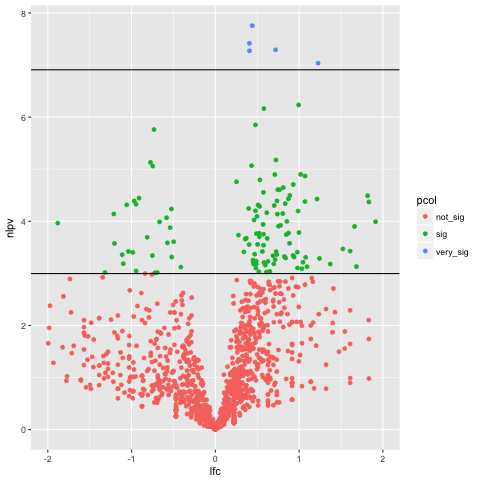

In [21]:
%%R -i twdf -i ttestdf -i fldf -i grdf

flmean = rowSums(fldf) / ncol(fldf)
grmean = rowSums(grdf) / ncol(grdf)

lfc = log(flmean / grmean)
nlpv = -log(ttestdf)

p5 = -log(0.05)
p1k = -log(0.001)

pcol = lapply(nlpv, FUN=function(p){
    if(p > p1k){
        return('very_sig')
    } else if(p > p5){
        return('sig')
    }
    return('not_sig')
})
pcol = unlist(pcol)

df = data.frame(lfc, nlpv, pcol)
df = df[!is.infinite(unlist(df['lfc'])),]
ggplot(df, aes(x=lfc, y=nlpv, color=pcol)) +
    geom_point() +
    geom_hline(yintercept=p5) + 
    geom_hline(yintercept=p1k) +
    xlim(-2,2)

# AMRs

## AMR Fecal

In [22]:
amrfs = glob(resdir + '*.resistome_amrs.mech.tsv')

def parseAmrF(fname):
    out = {}
    with open(fname) as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            samp, mech, val = line.strip().split('\t')
            out[mech] = int(val)
    return out

tbl = {samp(fname): parseAmrF(fname) for fname in amrfs}
amrs = pd.DataFrame(tbl).fillna(0).transpose()


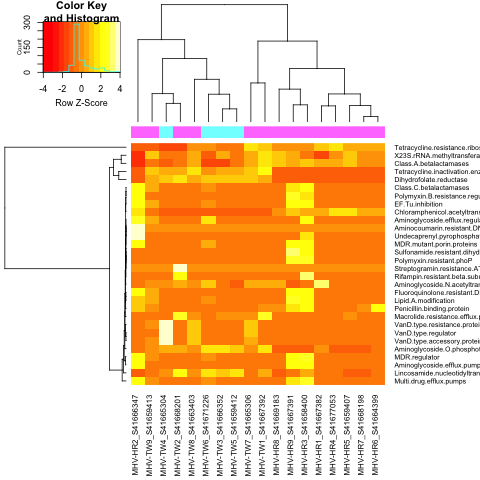

In [23]:
%%R -i amrs -i mdata

md = mdata[mdata["twin"] != "unk",]
amrs = amrs[rownames(md),]
amrs = t(amrs)
amrs = amrs[rowSums(amrs) > 0,]

heatmap.2(as.matrix(amrs), scale="row", ColSideColors=ascols(md["flight"], cm.colors), trace="none", mar=c(10,10))


# Pathways

## Pathways Fecal

In [28]:


ngenefs = glob(resdir + '*.humann2_normalize_genes.norm_genes.tsv')

def parseGeneF(fname):
    out = {}
    with open(fname) as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            line = line.strip()
            if line[0] == '#':
                continue
            gene, val = line.split('\t')
            val = float(val)
            if val < 0.001:
                continue
            if '|' in gene:
                continue
            out[gene] = val
    return out

tbl = {samp(fname): parseGeneF(fname) for fname in ngenefs}
ngenes = pd.DataFrame(tbl).fillna(0).transpose()
ngenes

,UniRef90_A0A015P9C8,UniRef90_A0A015T1I1,UniRef90_A0A015V1D1,UniRef90_A0A016D9U3,UniRef90_A0A016JHV3,UniRef90_A0A016KDX5,UniRef90_A0A016KDZ4,UniRef90_A0A016LWS1,UniRef90_A0A017N0B5,UniRef90_A0A017PFQ0,...,UniRef90_X1UDI6,UniRef90_X1UEL7,UniRef90_X1UIZ8,UniRef90_X1V349,UniRef90_X1V871,UniRef90_X1VEE2,UniRef90_X1VHR5,UniRef90_X6LPE5,UniRef90_X6LSL4,UniRef90_X6LTD6
011515_TW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002605,0.000000,0.000000,0.001716,0.000000,0.000000,0.00000,0.002121,0.000000,0.000000
012015_HR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003541,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.002694,0.000000,0.000000
012016_HR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006756,0.001474,0.000000,0.000000,0.001291,0.001197,0.00116,0.006080,0.001624,0.000000
012715_TW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005251,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.004189,0.000000,0.000000
030116_TW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005185,0.000000,0.001013,0.001232,0.000000,0.000000,0.00000,0.004206,0.000000,0.000000
040616_TW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005473,0.001043,0.001176,0.000000,0.000000,0.000000,0.00000,0.003996,0.000000,0.000000
041015_TW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002704,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.002015,0.000000,0.000000
050616_HR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003418,0.000000,0.001044,0.003677,0.000000,0.000000,0.00000,0.003062,0.000000,0.000000
061115_TW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004334,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.003304,0.000000,0.000000
061416_TW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005568,0.001106,0.001275,0.004975,0.000000,0.000000,0.00000,0.004480,0.001118,0.000000


In [48]:
md = mdata[mdata['twin'] =='TW']

ngenest = ngenes.loc[md.index].fillna(0)

flight = (md['flight'] == 'flight')
ground = (md['flight'] == 'ground')

fldf = ngenest[flight].transpose()
grdf = ngenest[ground].transpose()

ttestdf = ttest_ind(fldf, grdf, axis=1)[1]
ngenest.transpose()[ttestdf < 0.05]

/Users/dcdanko/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/dcdanko/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/dcdanko/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/dcdanko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


,MHV-TW1_S41667392,MHV-TW2_S41668201,MHV-TW3_S41666352,MHV-TW4_S41665304,MHV-TW5_S41659412,MHV-TW6_S41671226,MHV-TW7_S41665306,MHV-TW8_S41663403,MHV-TW9_S41659413
UniRef90_A5ZYV3,0.0,0.001438,0.001652,0.001406,0.001523,0.001297,0.0,0.0,0.0
UniRef90_C0CLE0,0.0,0.000000,0.001373,0.000000,0.001354,0.001587,0.0,0.0,0.0
UniRef90_K0XC19,0.0,0.000000,0.001712,0.001279,0.001472,0.000000,0.0,0.0,0.0


In [50]:
%%R -i ngenest -i ttestdf -i fldf -i grdf

flmean = rowSums(fldf) / ncol(fldf)
grmean = rowSums(grdf) / ncol(grdf)

is.na(ttestdf) = 1
print(ttestdf)
lfc = log(flmean / grmean)
nlpv = -log(ttestdf)

p5 = -log(0.05)

pcol = lapply(nlpv, FUN=function(p){
    if(p > p5){
        return('sig')
    }
    return('not_sig')
})
pcol = unlist(pcol)

df = data.frame(lfc, nlpv, pcol)
df = df[!is.infinite(unlist(df['lfc'])),]
ggplot(df, aes(x=lfc, y=nlpv, color=pcol)) +
    geom_point() +
    geom_hline(yintercept=p5) + 
    xlim(-2,2)

  [1]          NA         NaN         NaN         NaN 0.194496953 0.444721208
  [7] 0.687316824         NaN         NaN         NaN         NaN         NaN
 [13]         NaN         NaN         NaN         NaN         NaN         NaN
 [19]         NaN         NaN         NaN         NaN         NaN         NaN
 [25]         NaN         NaN         NaN         NaN         NaN         NaN
 [31]         NaN         NaN         NaN         NaN         NaN         NaN
 [37] 0.292351992 0.407083822 0.009334226 0.389815990         NaN 0.407083822
 [43]         NaN         NaN         NaN         NaN         NaN         NaN
 [49] 0.069108795 0.407083822         NaN 0.193044210         NaN         NaN
 [55] 0.669898767         NaN         NaN         NaN         NaN         NaN
 [61]         NaN         NaN         NaN 0.011769009 0.095106008         NaN
 [67]         NaN 0.531323945 0.516858379 0.400996171         NaN         NaN
 [73]         NaN         NaN         NaN         NaN 0.19554134

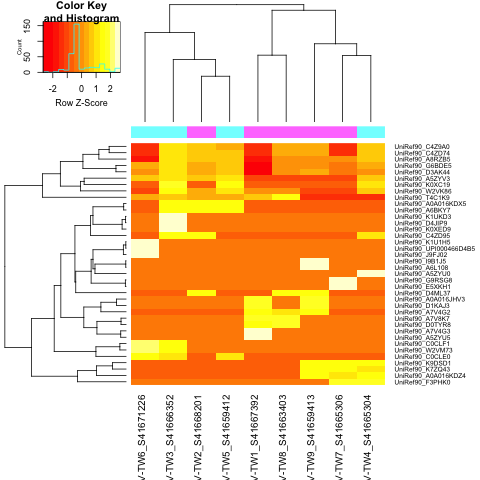

In [26]:
%%R -i ngenes -i mdata

md = mdata[mdata["twin"] == "TW",]
ng = ngenes[rownames(md),]
ng = t(ng)
ng = ng[rowSums(ng) > 0,]
heatmap.2(as.matrix(ng), scale="row", ColSideColors=ascols(md["flight"], cm.colors), trace="none", mar=c(10,10))


# Anaerobes

## Anaerobes in Saliva

## Catylase Positive